# Import relevant packages

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.8 MB/s eta 0:00:00


In [ ]:
!pip install lightgbm

In [ ]:
!pip install yellowbrick

In [ ]:
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 19.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.linear_model import LinearRegression
%matplotlib inline
import warnings  as ws
ws.filterwarnings("ignore")

import sklearn.metrics as metrics
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor
from sklearn.kernel_ridge import KernelRidge
from xgboost.sklearn import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, BayesianRidge, SGDRegressor, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import explained_variance_score

from yellowbrick.regressor import prediction_error
from yellowbrick.regressor import residuals_plot
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.inspection import PartialDependenceDisplay
import shap

# print the JS visualization code to the notebook
shap.initjs()

# Loading the Data

In [ ]:
df = pd.read_csv("/content/Medicalpremium.csv")

df.info()
df.head()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 986 entries, 0 to 985
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   Age                      986 non-null    int64
 1   Diabetes                 986 non-null    int64
 2   BloodPressureProblems    986 non-null    int64
 3   AnyTransplants           986 non-null    int64
 4   AnyChronicDiseases       986 non-null    int64
 5   Height                   986 non-null    int64
 6   Weight                   986 non-null    int64
 7   KnownAllergies           986 non-null    int64
 8   HistoryOfCancerInFamily  986 non-null    int64
 9   NumberOfMajorSurgeries   986 non-null    int64
 10  PremiumPrice             986 non-null    int64
dtypes: int64(11)
memory usage: 84.9 KB


,Age,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,Height,Weight,KnownAllergies,HistoryOfCancerInFamily,NumberOfMajorSurgeries,PremiumPrice
0,45,0,0,0,0,155,57,0,0,0,25000
1,60,1,0,0,0,180,73,0,0,0,29000
2,36,1,1,0,0,158,59,0,0,1,23000
3,52,1,1,0,1,183,93,0,0,2,28000
4,38,0,0,0,1,166,88,0,0,1,23000


In [ ]:
df.shape

(986, 11)

In [ ]:
df.duplicated().sum()

0

In [ ]:
df.drop_duplicates(inplace=True)
df.duplicated(keep=False)
df.shape

(986, 11)

In [ ]:
df.isnull().sum()

,0
Age,0
Diabetes,0
BloodPressureProblems,0
AnyTransplants,0
AnyChronicDiseases,0
Height,0
Weight,0
KnownAllergies,0
HistoryOfCancerInFamily,0
NumberOfMajorSurgeries,0


In [ ]:
df.shape

(986, 11)

# EDA on the Data

In [ ]:

df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,986.000,41.745,13.963,18.000,30.000,42.000,53.000,66.000
Diabetes,986.000,0.420,0.494,0.000,0.000,0.000,1.000,1.000
BloodPressureProblems,986.000,0.469,0.499,0.000,0.000,0.000,1.000,1.000
AnyTransplants,986.000,0.056,0.230,0.000,0.000,0.000,0.000,1.000
AnyChronicDiseases,986.000,0.181,0.385,0.000,0.000,0.000,0.000,1.000
Height,986.000,168.183,10.098,145.000,161.000,168.000,176.000,188.000
Weight,986.000,76.950,14.265,51.000,67.000,75.000,87.000,132.000
KnownAllergies,986.000,0.215,0.411,0.000,0.000,0.000,0.000,1.000
HistoryOfCancerInFamily,986.000,0.118,0.322,0.000,0.000,0.000,0.000,1.000
NumberOfMajorSurgeries,986.000,0.667,0.749,0.000,0.000,1.000,1.000,3.000


In [ ]:
cols = df.columns
cols

Index(['Age', 'Diabetes', 'BloodPressureProblems', 'AnyTransplants',
       'AnyChronicDiseases', 'Height', 'Weight', 'KnownAllergies',
       'HistoryOfCancerInFamily', 'NumberOfMajorSurgeries', 'PremiumPrice'],
      dtype='object')

In [ ]:
pr_lab=['Low','Basic','Average','High','SuperHigh']
df['PremiumLabel']=pr_bins=pd.cut(df['PremiumPrice'],bins=5,labels=pr_lab,precision=0)

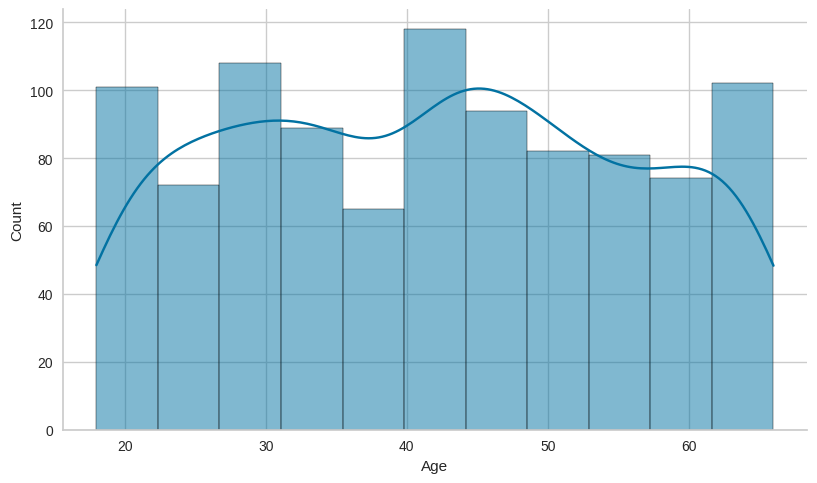

In [ ]:
sns.displot(x='Age',data=df,aspect=10/6,kde=True)

Text(0.5, 1.0, 'Insurance Premium Price by Age')

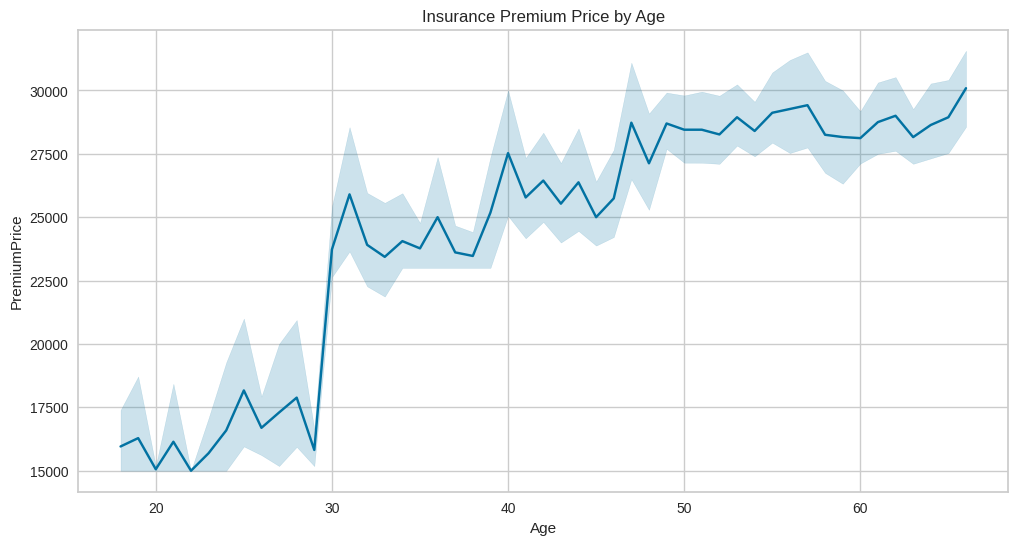

In [ ]:
fig,ax=plt.subplots(figsize=(12,6))
sns.lineplot(x=df.Age,y=df.PremiumPrice).set_title('Insurance Premium Price by Age')

Text(0.5, 1.0, 'Distribution of the Insurance Premium Price')

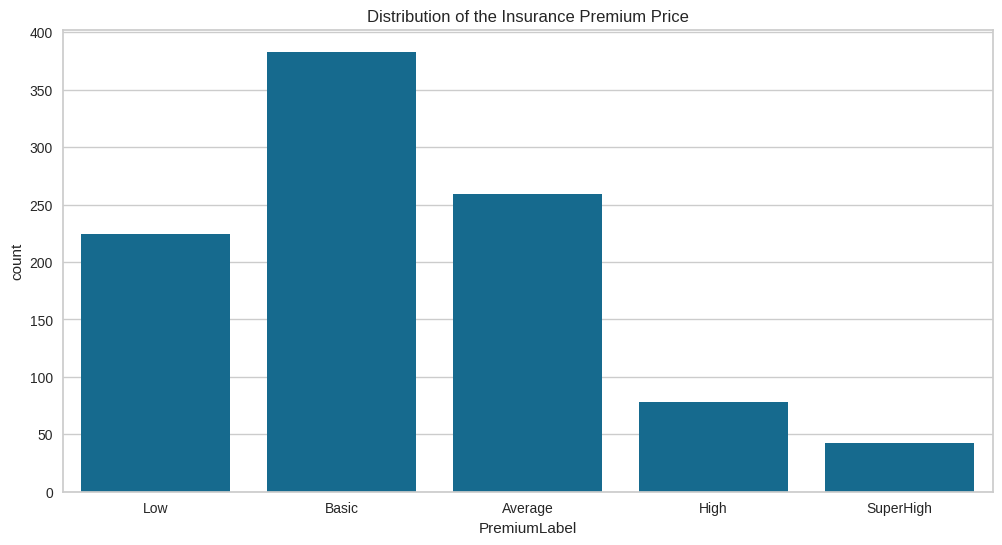

In [ ]:
fig,ax=plt.subplots(figsize=(12,6))
sns.countplot(x='PremiumLabel', data=df,ax=ax).set_title('Distribution of the Insurance Premium Price')

In [ ]:
df.groupby(['PremiumLabel','NumberOfMajorSurgeries'])['NumberOfMajorSurgeries'].count()

PremiumLabel  NumberOfMajorSurgeries
Low           0                         142
              1                          82
              2                           0
              3                           0
Basic         0                         226
              1                         156
              2                           1
              3                           0
Average       0                          67
              1                          59
              2                         117
              3                          16
High          0                          22
              1                          56
              2                           0
              3                           0
SuperHigh     0                          22
              1                          19
              2                           1
              3                           0
Name: NumberOfMajorSurgeries, dtype: int64

In [ ]:
cols

Index(['Age', 'Diabetes', 'BloodPressureProblems', 'AnyTransplants',
       'AnyChronicDiseases', 'Height', 'Weight', 'KnownAllergies',
       'HistoryOfCancerInFamily', 'NumberOfMajorSurgeries', 'PremiumPrice'],
      dtype='object')

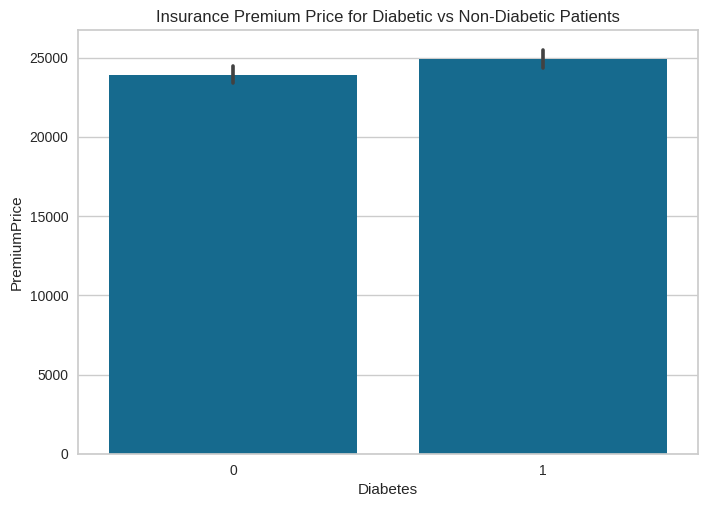

In [ ]:
plot = sns.barplot(data=df, x="Diabetes", y= "PremiumPrice" ).set_title('Insurance Premium Price for Diabetic vs Non-Diabetic Patients')

Text(0.5, 0.98, 'Density plot for Diabetic vs Non-Diabetic Patients')

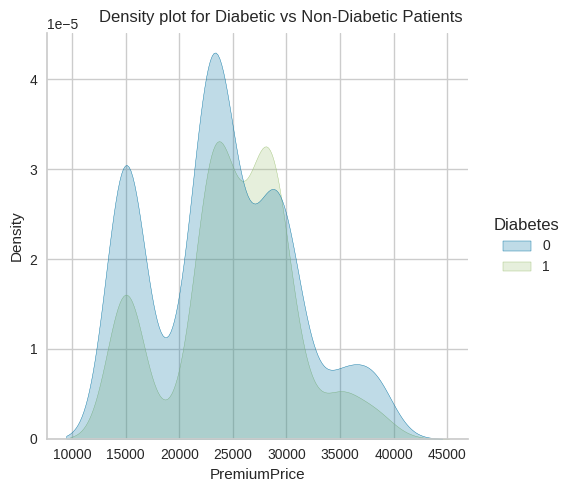

In [ ]:

plot= sns.displot(df, x="PremiumPrice", hue="Diabetes", kind="kde", fill=True, )
plot.fig.suptitle('Density plot for Diabetic vs Non-Diabetic Patients',
                  fontsize=12, fontdict={"weight": "bold"})

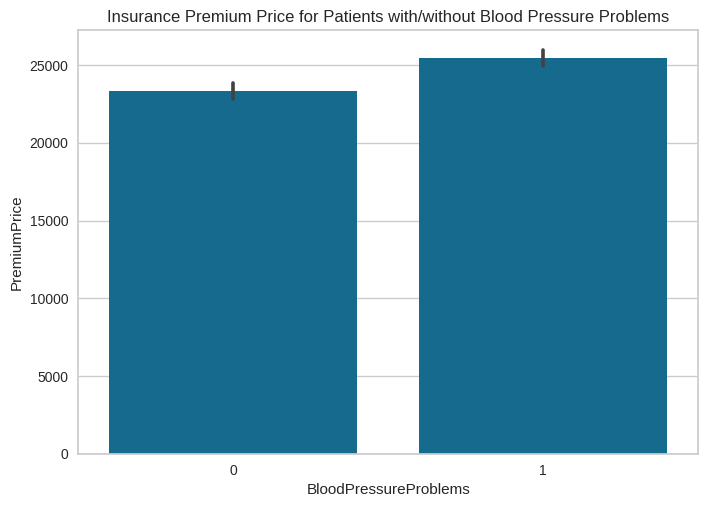

In [ ]:
plot = sns.barplot(data=df, x="BloodPressureProblems", y= "PremiumPrice" ).set_title('Insurance Premium Price for Patients with/without Blood Pressure Problems')


Text(0.5, 0.98, 'Density plot for Patients with/without Blood Pressure Problems')

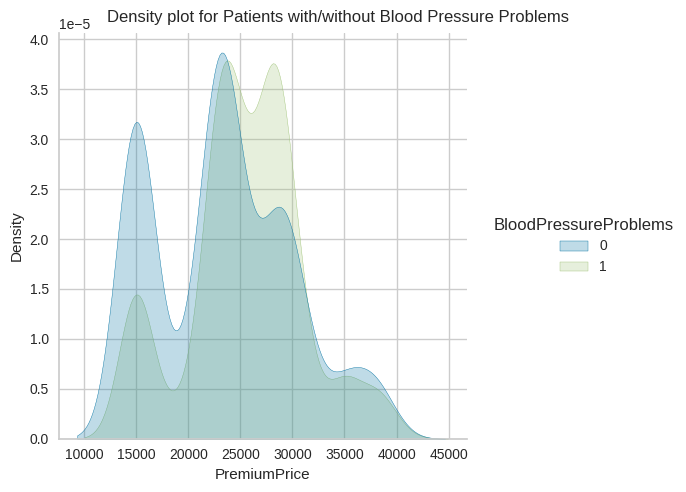

In [ ]:
plot= sns.displot(df, x="PremiumPrice", hue="BloodPressureProblems", kind="kde", fill=True, )
plot.fig.suptitle('Density plot for Patients with/without Blood Pressure Problems',
                  fontsize=12, fontdict={"weight": "bold"})

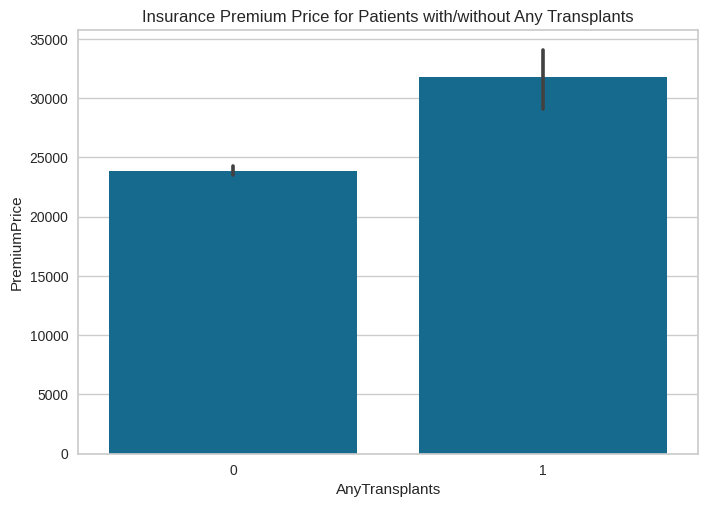

In [ ]:
plot = sns.barplot(data=df, x="AnyTransplants", y= "PremiumPrice" ).set_title('Insurance Premium Price for Patients with/without Any Transplants')


Text(0.5, 0.98, 'Density plot for Patients with/without Any Transplants')

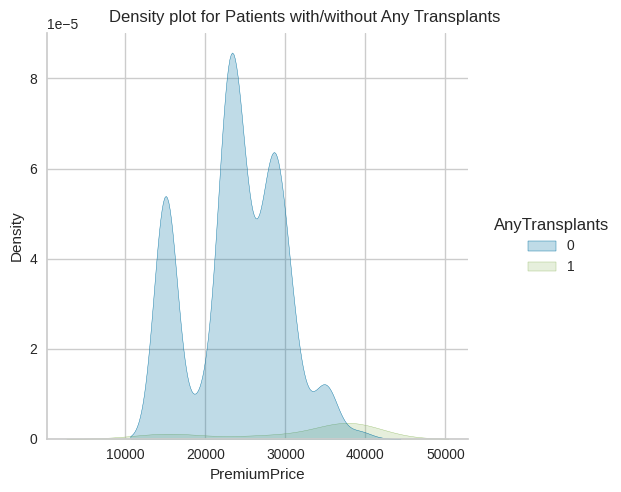

In [ ]:
plot= sns.displot(df, x="PremiumPrice", hue="AnyTransplants", kind="kde", fill=True, )
plot.fig.suptitle('Density plot for Patients with/without Any Transplants',
                  fontsize=12, fontdict={"weight": "bold"})

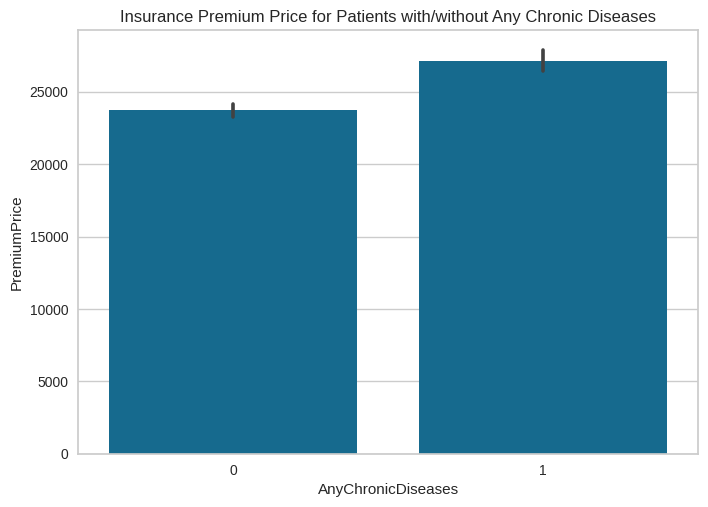

In [ ]:
plot = sns.barplot(data=df, x="AnyChronicDiseases", y= "PremiumPrice" ).set_title('Insurance Premium Price for Patients with/without Any Chronic Diseases')

Text(0.5, 0.98, 'Density plot for Patients with/without Any Chronic Diseases')

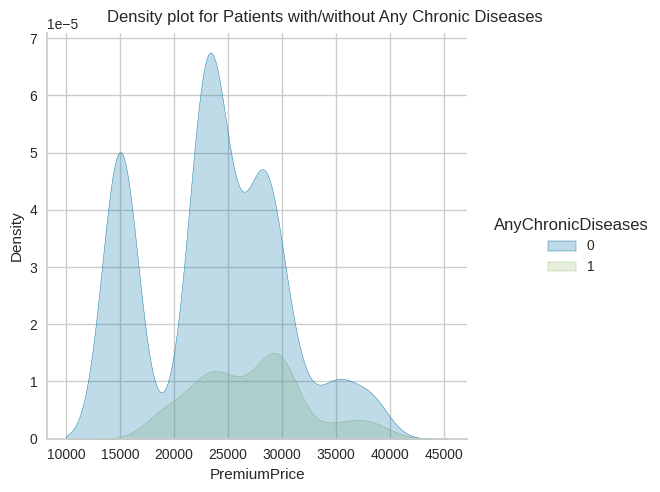

In [ ]:
plot= sns.displot(df, x="PremiumPrice", hue="AnyChronicDiseases", kind="kde", fill=True, )
plot.fig.suptitle('Density plot for Patients with/without Any Chronic Diseases',
                  fontsize=12, fontdict={"weight": "bold"})

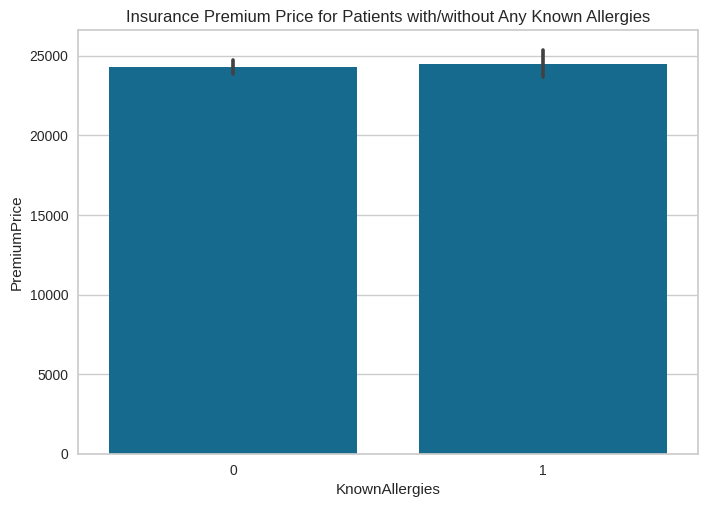

In [ ]:
plot = sns.barplot(data=df, x="KnownAllergies", y= "PremiumPrice" ).set_title('Insurance Premium Price for Patients with/without Any Known Allergies')

Text(0.5, 0.98, 'Density plot for Patients with/without Any Known Allergies')

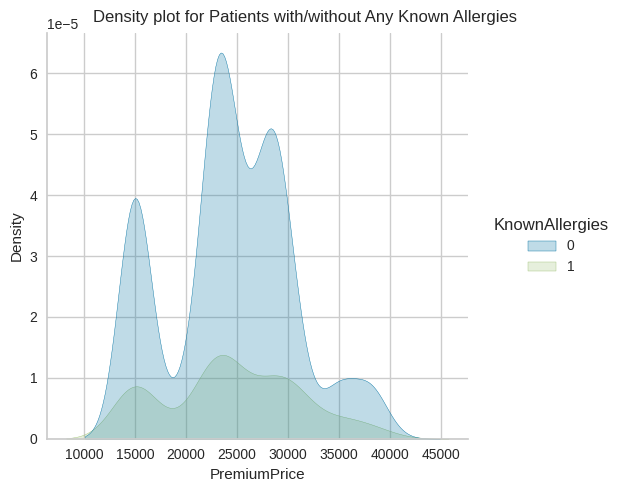

In [ ]:
plot= sns.displot(df, x="PremiumPrice", hue="KnownAllergies", kind="kde", fill=True, )
plot.fig.suptitle('Density plot for Patients with/without Any Known Allergies',
                  fontsize=12, fontdict={"weight": "bold"})

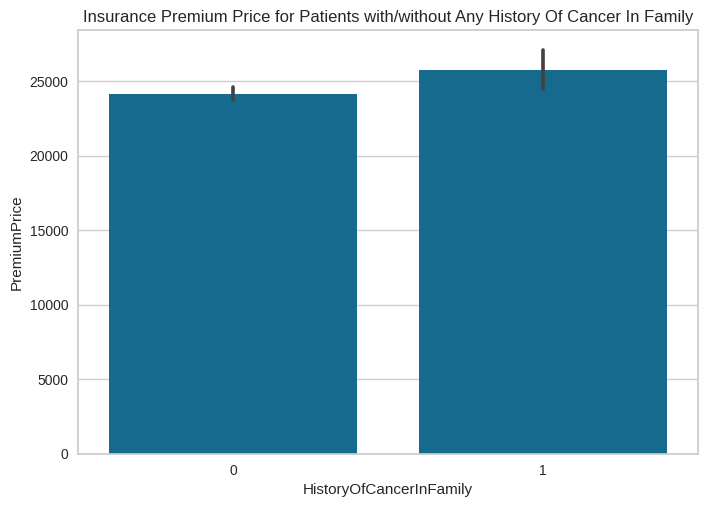

In [ ]:
plot = sns.barplot(data=df, x="HistoryOfCancerInFamily", y= "PremiumPrice" ).set_title('Insurance Premium Price for Patients with/without Any History Of Cancer In Family')

Text(0.5, 0.98, 'Density plot for Patients with/without Any History Of Cancer In Family')

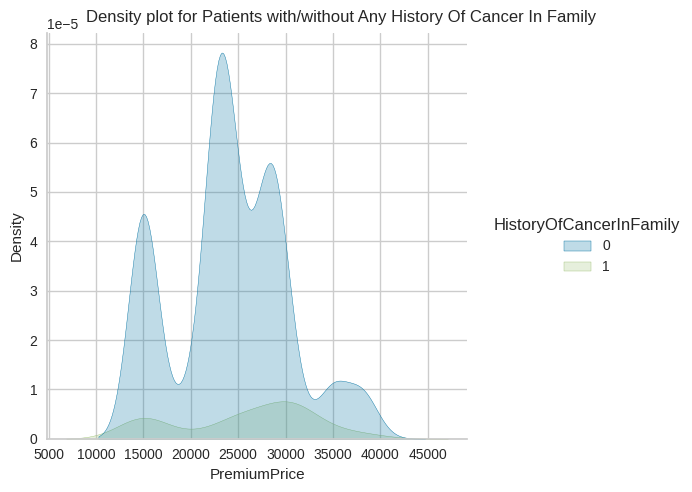

In [ ]:

plot= sns.displot(df, x="PremiumPrice", hue="HistoryOfCancerInFamily", kind="kde", fill=True, )
plot.fig.suptitle('Density plot for Patients with/without Any History Of Cancer In Family',
                  fontsize=12, fontdict={"weight": "bold"})

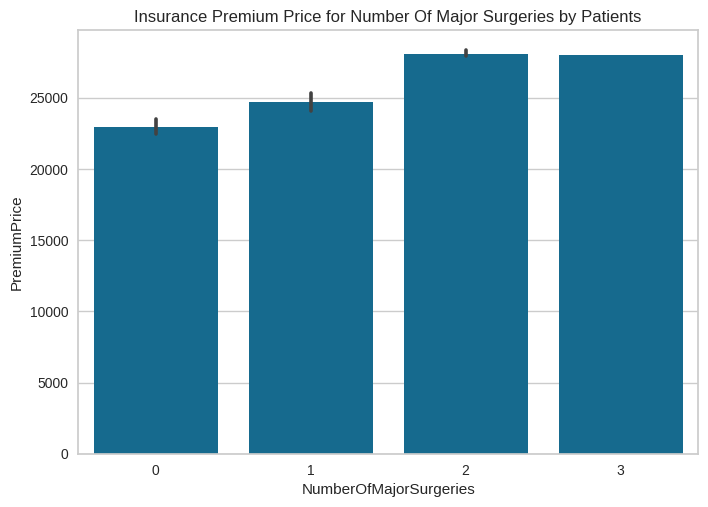

In [ ]:
plot = sns.barplot(data=df, x="NumberOfMajorSurgeries", y= "PremiumPrice" ).set_title('Insurance Premium Price for Number Of Major Surgeries by Patients')

Text(0.5, 0.98, 'Density plot for Number Of Major Surgeries by Patients')

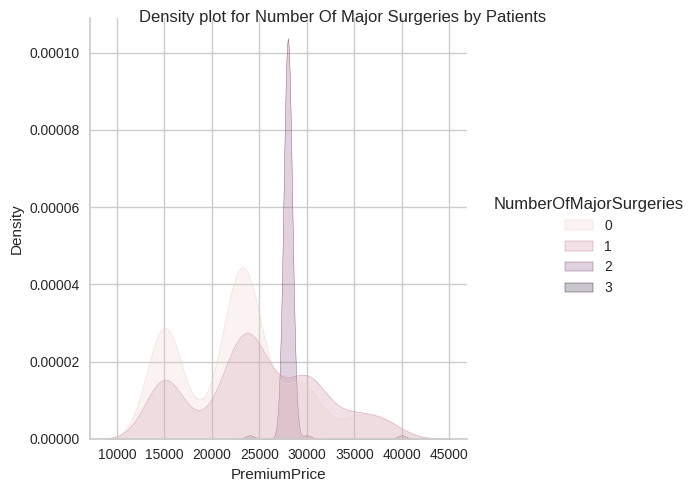

In [ ]:
plot= sns.displot(df, x="PremiumPrice", hue="NumberOfMajorSurgeries", kind="kde", fill=True, )
plot.fig.suptitle('Density plot for Number Of Major Surgeries by Patients',
                  fontsize=12, fontdict={"weight": "bold"})

In [ ]:
# Calculating BMI
w = df['Weight'];
h = df['Height'];

#bmi = 10000*(weight/(height*height));

df['BMI'] = 10000*(w/(h*h))

df.head()

,Age,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,Height,Weight,KnownAllergies,HistoryOfCancerInFamily,NumberOfMajorSurgeries,PremiumPrice,PremiumLabel,BMI
0,45,0,0,0,0,155,57,0,0,0,25000,Basic,23.725
1,60,1,0,0,0,180,73,0,0,0,29000,Average,22.531
2,36,1,1,0,0,158,59,0,0,1,23000,Basic,23.634
3,52,1,1,0,1,183,93,0,0,2,28000,Average,27.770
4,38,0,0,0,1,166,88,0,0,1,23000,Basic,31.935


In [ ]:
df['BMI_Status'] = np.select(
    [df['BMI'] < 18.499999,
     df['BMI'] >= 30,
     df['BMI'].between(18.5, 24.999999),
     df['BMI'].between(25, 29.9999999)],
    ['Underweight', 'Obesse', 'Normal', 'Overweight']
)

In [ ]:
df.head()

,Age,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,Height,Weight,KnownAllergies,HistoryOfCancerInFamily,NumberOfMajorSurgeries,PremiumPrice,PremiumLabel,BMI,BMI_Status
0,45,0,0,0,0,155,57,0,0,0,25000,Basic,23.725,Normal
1,60,1,0,0,0,180,73,0,0,0,29000,Average,22.531,Normal
2,36,1,1,0,0,158,59,0,0,1,23000,Basic,23.634,Normal
3,52,1,1,0,1,183,93,0,0,2,28000,Average,27.770,Overweight
4,38,0,0,0,1,166,88,0,0,1,23000,Basic,31.935,Obesse


In [ ]:
df.groupby(['PremiumLabel','BMI_Status'])['BMI_Status'].count()

PremiumLabel  BMI_Status 
Low           Normal          71
              Obesse          70
              Overweight      74
              Underweight      9
Basic         Normal         151
              Obesse          88
              Overweight     120
              Underweight     24
Average       Normal          74
              Obesse          80
              Overweight     100
              Underweight      5
High          Normal          13
              Obesse          49
              Overweight      15
              Underweight      1
SuperHigh     Normal          10
              Obesse          16
              Overweight      16
              Underweight      0
Name: BMI_Status, dtype: int64

<Axes: xlabel='PremiumLabel', ylabel='count'>

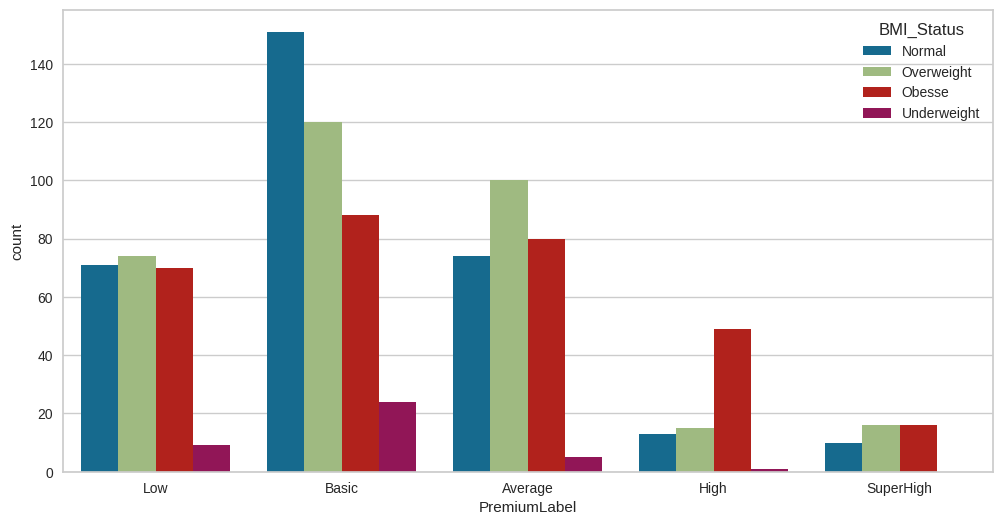

In [ ]:
fig,ax=plt.subplots(figsize=(12,6))
sns.countplot(x='PremiumLabel',hue='BMI_Status', data=df,ax=ax)

Text(0.5, 1.0, 'Insurance Premium Price for Various BMI Status')

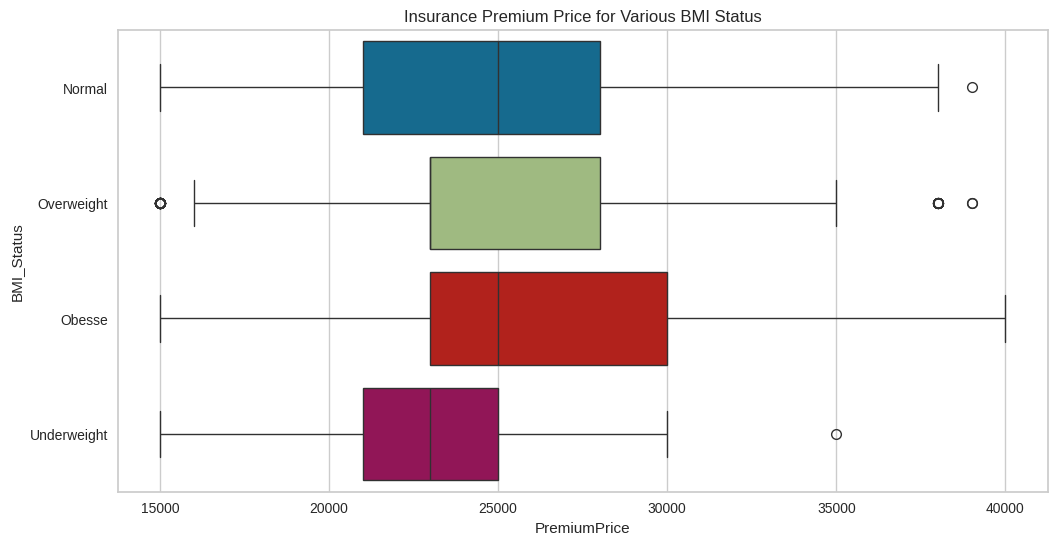

In [ ]:
fig,ax=plt.subplots(figsize=(12,6))
sns.boxplot(data=df, x="PremiumPrice", y="BMI_Status", hue="BMI_Status", dodge=False).set_title('Insurance Premium Price for Various BMI Status')

<Axes: >

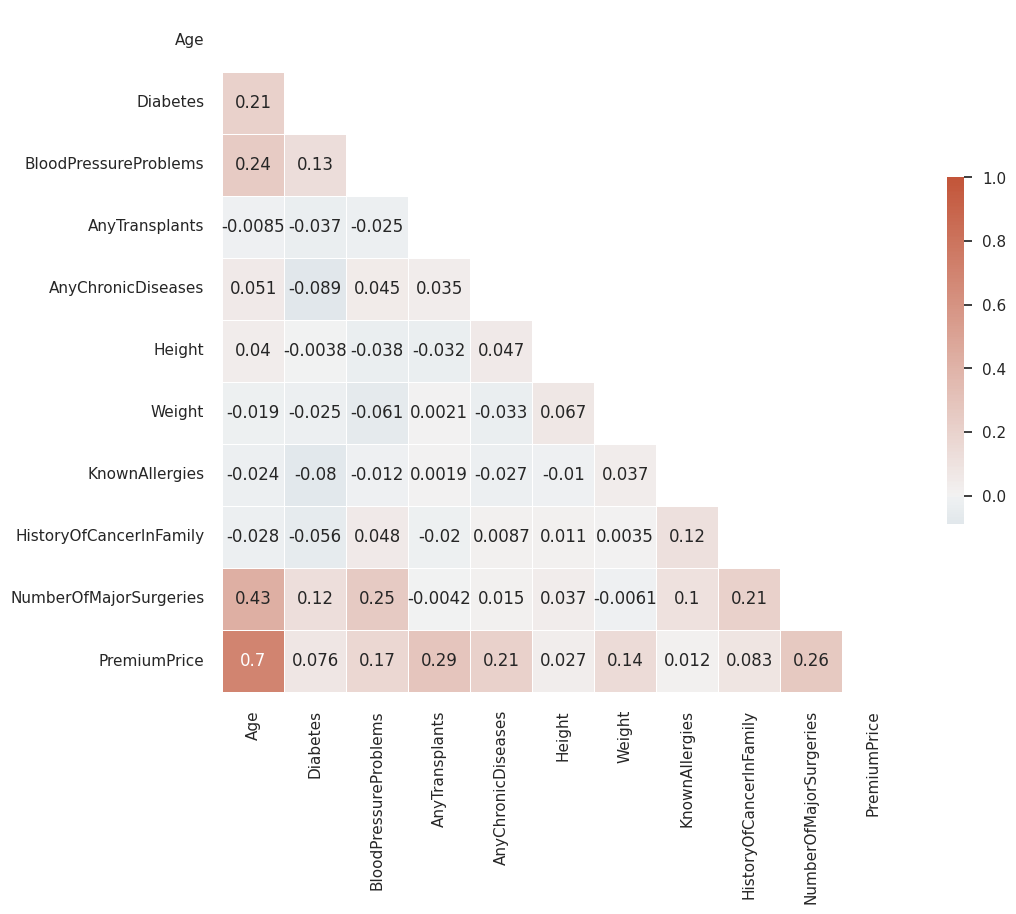

In [ ]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")

# Generate a large random dataset
rs = df
d = pd.DataFrame(data=rs,
                 columns=cols)

# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, mask=mask, cmap=cmap, vmax=1.0, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
df=pd.get_dummies(data=df,columns=['BMI_Status'])

In [ ]:
df.head()

,Age,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,Height,Weight,KnownAllergies,HistoryOfCancerInFamily,NumberOfMajorSurgeries,PremiumPrice,PremiumLabel,BMI,BMI_Status_Normal,BMI_Status_Obesse,BMI_Status_Overweight,BMI_Status_Underweight
0,45,0,0,0,0,155,57,0,0,0,25000,Basic,23.725,True,False,False,False
1,60,1,0,0,0,180,73,0,0,0,29000,Average,22.531,True,False,False,False
2,36,1,1,0,0,158,59,0,0,1,23000,Basic,23.634,True,False,False,False
3,52,1,1,0,1,183,93,0,0,2,28000,Average,27.770,False,False,True,False
4,38,0,0,0,1,166,88,0,0,1,23000,Basic,31.935,False,True,False,False


In [ ]:
df.shape

(986, 17)

In [ ]:
df.columns

Index(['Age', 'Diabetes', 'BloodPressureProblems', 'AnyTransplants',
       'AnyChronicDiseases', 'Height', 'Weight', 'KnownAllergies',
       'HistoryOfCancerInFamily', 'NumberOfMajorSurgeries', 'PremiumPrice',
       'PremiumLabel', 'BMI', 'BMI_Status_Normal', 'BMI_Status_Obesse',
       'BMI_Status_Overweight', 'BMI_Status_Underweight'],
      dtype='object')

# Building the ML model

In [ ]:
x=df.drop(['PremiumPrice', 'PremiumLabel', 'Height', 'Weight', 'BMI_Status_Normal', 'BMI_Status_Obesse', 'BMI_Status_Overweight',
       'BMI_Status_Underweight'], axis=1)
y=df['PremiumPrice']

In [ ]:
x.columns

Index(['Age', 'Diabetes', 'BloodPressureProblems', 'AnyTransplants',
       'AnyChronicDiseases', 'KnownAllergies', 'HistoryOfCancerInFamily',
       'NumberOfMajorSurgeries', 'BMI'],
      dtype='object')

### Data normalization

In [ ]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
xsc=sc.fit_transform(x)

In [ ]:
xsc=pd.DataFrame(xsc,columns=x.columns)

In [ ]:
from sklearn.feature_selection import mutual_info_regression
mi_scores = mutual_info_regression(xsc,y)
mi_scores = pd.Series(mi_scores, name="MI Scores",index=xsc.columns)
mi_scores = mi_scores.sort_values(ascending=False)
(mi_scores*100).head(15).index

Index(['Age', 'NumberOfMajorSurgeries', 'AnyChronicDiseases', 'AnyTransplants',
       'HistoryOfCancerInFamily', 'BMI', 'BloodPressureProblems', 'Diabetes',
       'KnownAllergies'],
      dtype='object')

In [ ]:
fea=list((mi_scores*100).head(15).index)
xsc=xsc[fea]
xsc

,Age,NumberOfMajorSurgeries,AnyChronicDiseases,AnyTransplants,HistoryOfCancerInFamily,BMI,BloodPressureProblems,Diabetes,KnownAllergies
0,0.233,-0.891,-0.469,-0.243,-0.365,-0.636,-0.939,-0.851,-0.523
1,1.308,-0.891,-0.469,-0.243,-0.365,-0.839,-0.939,1.175,-0.523
2,-0.412,0.444,-0.469,-0.243,-0.365,-0.651,1.065,1.175,-0.523
3,0.735,1.780,2.131,-0.243,-0.365,0.053,1.065,1.175,-0.523
4,-0.268,0.444,2.131,-0.243,-0.365,0.761,-0.939,-0.851,-0.523
...,...,...,...,...,...,...,...,...,...
981,-1.701,-0.891,-0.469,-0.243,-0.365,-0.681,-0.939,-0.851,-0.523
982,1.595,3.115,-0.469,-0.243,-0.365,0.416,1.065,1.175,-0.523
983,1.021,0.444,-0.469,-0.243,-0.365,0.356,1.065,-0.851,-0.523
984,0.377,0.444,-0.469,-0.243,-0.365,0.303,1.065,1.175,1.911


In [ ]:
y.shape

(986,)

### Split train

In [ ]:
#X=df.drop(['PremiumPrice'],axis=1)
#Y=df[['PremiumPrice']]
from sklearn.linear_model import LinearRegression,Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
l1=[]
l2=[]
l3=[]
cvs=0
for i in range(40,50):
    xtrain,xtest,ytrain,ytest=train_test_split(xsc, y, random_state=i, test_size=0.25)
    lrmodel=LinearRegression()
    lrmodel.fit(xtrain,ytrain)
    l1.append(lrmodel.score(xtrain,ytrain))
    l2.append(lrmodel.score(xtest,ytest))
    cvs=(cross_val_score(lrmodel,xsc,y,cv=5,)).mean()
    l3.append(cvs)
    df1=pd.DataFrame({'train acc':l1,'test acc':l2,'cvs':l3})
df1


,train acc,test acc,cvs
0,0.637,0.628,0.626
1,0.611,0.709,0.626
2,0.612,0.685,0.626
3,0.619,0.678,0.626
4,0.664,0.539,0.626
5,0.612,0.693,0.626
6,0.624,0.665,0.626
7,0.625,0.663,0.626
8,0.620,0.675,0.626
9,0.675,0.502,0.626


# LR Model

In [ ]:
xtrain,xtest,ytrain,ytest=train_test_split(xsc,y,test_size=0.25,random_state=41)
lrmodel=LinearRegression()
lrmodel.fit(xtrain,ytrain)
print(lrmodel.score(xtrain,ytrain))
print(lrmodel.score(xtest,ytest))
print(cross_val_score(lrmodel,xsc,y,cv=5,).mean())


0.6111971888559355
0.7085652213125867
0.6255626958404497


In [ ]:
acc_lr_Train = lrmodel.score(xtrain,ytrain)
print('R^2 Train:', acc_lr_Train)

acc_lr_Test = lrmodel.score(xtest,ytest)
print('R^2 Test:', acc_lr_Test)

acc_lr_CV = cross_val_score(lrmodel,xsc,y,cv=5,).mean()
print('R^2 CV:', acc_lr_CV)



R^2 Train: 0.6111971888559355
R^2 Test: 0.7085652213125867
R^2 CV: 0.6255626958404497


# SVM Model

In [ ]:
import time
import psutil

# Record the start time
start_time = time.time()
# Function to get memory usage
def get_memory_usage():
    process = psutil.Process()
    memory_info = process.memory_info()
    return memory_info.rss / (1024 * 1024)  # Convert to megabytes

# Record memory usage before running your code
start_memory = get_memory_usage()




from sklearn.metrics import r2_score
svrmodel=SVR()
svrmodel.fit(xtrain,ytrain)
ypredtrain1=svrmodel.predict(xtrain)
ypredtest1=svrmodel.predict(xtest)
print(r2_score(ytrain,ypredtrain1))
print(r2_score(ytest,ypredtest1))
print(cross_val_score(svrmodel,xsc,y,cv=5,).mean())



acc_SVM_Train = r2_score(ytrain,ypredtrain1)
print('R^2 Train:', acc_SVM_Train)

acc_SVM_Test = r2_score(ytest,ypredtest1)
print('R^2 Test:', acc_SVM_Test)

acc_SVM_CV = cross_val_score(svrmodel,xsc,y,cv=5,).mean()
print('R^2 CV:', acc_SVM_CV)



# other metrics

MAE_SVM_Test= metrics.mean_absolute_error(ytest,ypredtest1)
print('MAE:',MAE_SVM_Test)

MSE_SVM_Test = metrics.mean_squared_error(ytest,ypredtest1)
print('MSE:',MSE_SVM_Test)

RMSE_SVM_Test = np.sqrt(metrics.mean_squared_error(ytest,ypredtest1))
print('RMSE:', RMSE_SVM_Test)

MAPE_SVM_Test= (metrics.mean_absolute_percentage_error(ytest,ypredtest1))
print('MAPE:',MAPE_SVM_Test)




-0.03541346056671246
-0.028498546246157774
-0.03333576127734137
R^2 Train: -0.03541346056671246
R^2 Test: -0.028498546246157774
R^2 CV: -0.03333576127734137
MAE: 4742.603385803891
MSE: 37853547.70145163
RMSE: 6152.5236855660805
MAPE: 0.21276816737710638


# RF Model

In [ ]:
import time
import psutil

# Record the start time
start_time = time.time()
# Function to get memory usage
def get_memory_usage():
    process = psutil.Process()
    memory_info = process.memory_info()
    return memory_info.rss / (1024 * 1024)  # Convert to megabytes

# Record memory usage before running your code
start_memory = get_memory_usage()


rfmodel0=RandomForestRegressor(random_state=41)
rfmodel0.fit(xtrain,ytrain)
ypredtrain2=rfmodel0.predict(xtrain)
ypredtest2=rfmodel0.predict(xtest)
print(r2_score(ytrain,ypredtrain2))
print(r2_score(ytest,ypredtest2))
print(cross_val_score(rfmodel0,xsc,y,cv=5,).mean())

from sklearn.model_selection import GridSearchCV
estimator=RandomForestRegressor(random_state=41)
param_grid={'n_estimators':[60, 220, 40]}
grid1=GridSearchCV(estimator,param_grid,scoring="r2",cv=5)
grid1.fit(xtrain,ytrain)
print(grid1.best_params_)

rfmodel=grid1
rfmodel.fit(xtrain,ytrain)
ypredtrain2=rfmodel.predict(xtrain)
ypredtest2=rfmodel.predict(xtest)
print(r2_score(ytrain,ypredtrain2))
print(r2_score(ytest,ypredtest2))
print(cross_val_score(rfmodel,xsc,y,cv=5,).mean())



acc_RF_Train = (r2_score(ytrain,ypredtrain2))
print('R^2 Train:', acc_RF_Train)

acc_RF_Test = (r2_score(ytest,ypredtest2))
print('R^2 Test:', acc_RF_Test)

acc_RF_CV = cross_val_score(rfmodel,xsc,y,cv=5,).mean()
print('R^2 CV:', acc_RF_CV)


# other metrics

MAE_RF_Test= metrics.mean_absolute_error(ytest,ypredtest2)
print('MAE:',MAE_RF_Test)
MSE_RF_Test = metrics.mean_squared_error(ytest,ypredtest2)
print('MSE:',MSE_RF_Test)
RMSE_RF_Test = np.sqrt(metrics.mean_squared_error(ytest,ypredtest2))
print('RMSE:', RMSE_RF_Test)
MAPE_RF_Test= (metrics.mean_absolute_percentage_error(ytest,ypredtest2))
print('MAPE:',MAPE_RF_Test)




0.9553102380908046
0.8462020589057885
0.7334123814256103
{'n_estimators': 220}
0.958024263148998
0.841356824459806
0.7345237545834233
R^2 Train: 0.958024263148998
R^2 Test: 0.841356824459806
R^2 CV: 0.7345237545834233
MAE: 1375.0276039749724
MSE: 5838809.4321946
RMSE: 2416.362851931514
MAPE: 0.05800436575242116


## Learning Curve for RF model

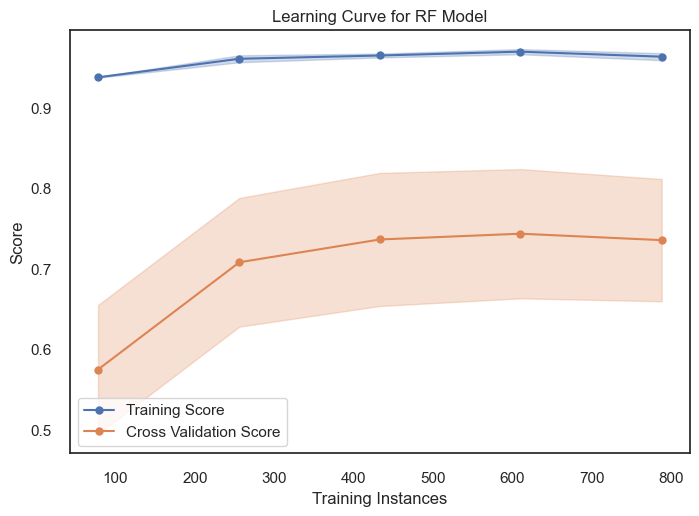

<Axes: title={'center': 'Learning Curve for RF Model'}, xlabel='Training Instances', ylabel='Score'>

In [ ]:
from yellowbrick.model_selection import learning_curve


visualizer = learning_curve(rfmodel,xsc,y,cv=5, scoring='r2', title="Learning Curve for RF Model")

visualizer.show()

## Residuals plot + Q-Q plot (yellowbrick) for RF model

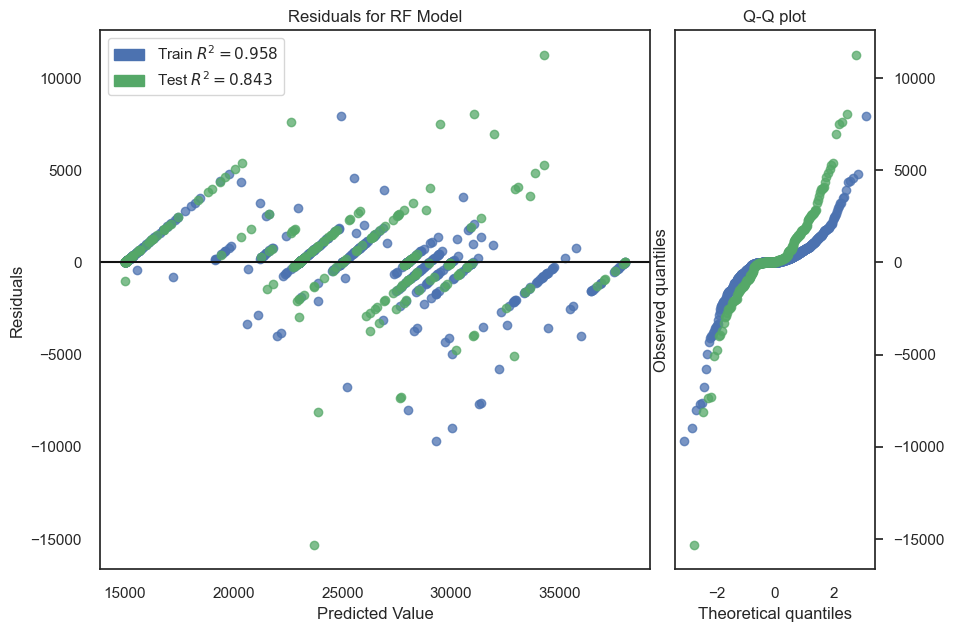

In [ ]:
fig, ax = plt.subplots(figsize=(10, 7))
_ = residuals_plot(estimator=rfmodel,
                   is_fitted=True,
                   ax=ax,
                   X_train=xtrain,
                   y_train=ytrain,
                   X_test=xtest,
                   y_test=ytest,
                   hist=False,
                   qqplot=True,
                  title="Residuals for RF Model"
                  )

## Prediction error plot (yellowbrick) for RF model

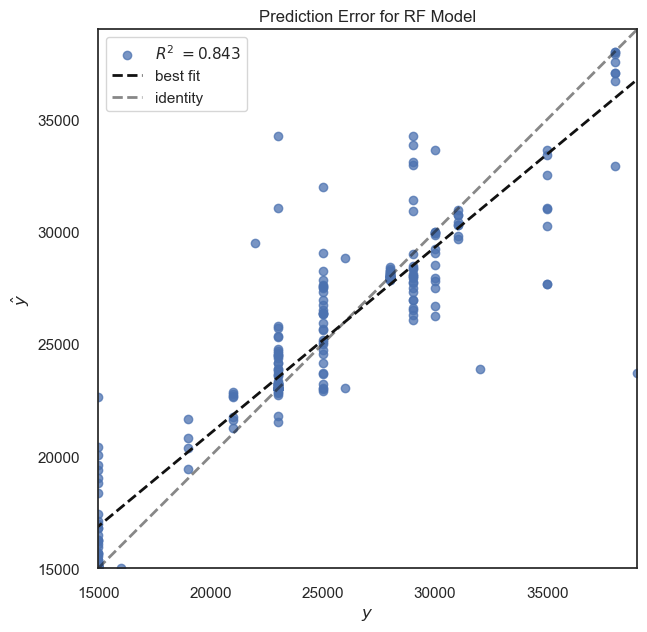

In [ ]:
fig, ax = plt.subplots(figsize=(10, 7))
_ = prediction_error(estimator=rfmodel,
                     is_fitted=True,
                     ax=ax,
                     X_train=xtrain,
                     y_train=ytrain,
                     X_test=xtest,
                     y_test=ytest,
                     title="Prediction Error for RF Model")

## SHAP Analysis for RF model

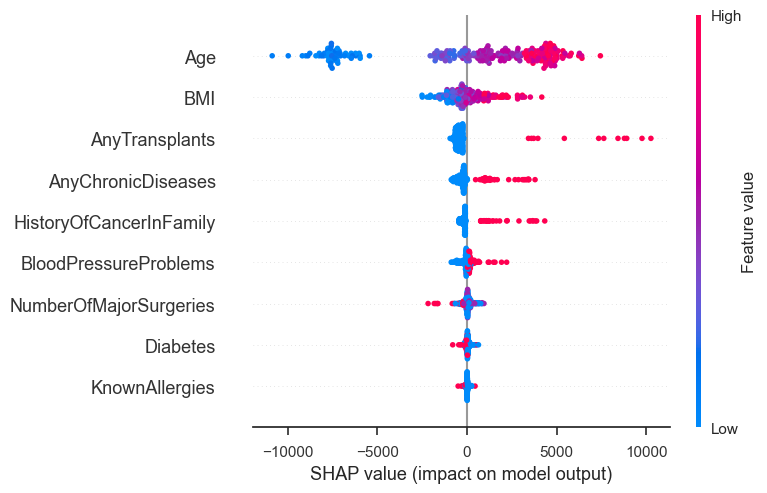

In [ ]:
# Shap analysis for RF model

explainer1 = shap.TreeExplainer(rfmodel0)
RF_shap_values = explainer1.shap_values(xtest)
shap.summary_plot(RF_shap_values, xtest)

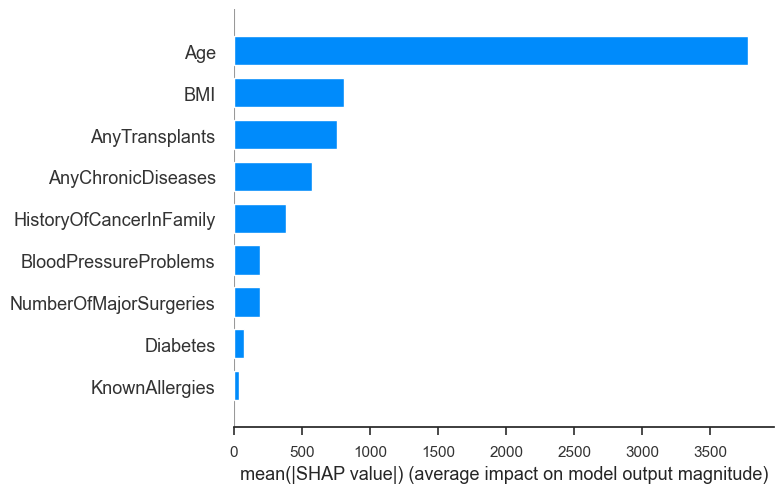

In [ ]:
shap.summary_plot(RF_shap_values, xtest, plot_type="bar")

In [ ]:
xtest.columns

Index(['Age', 'NumberOfMajorSurgeries', 'AnyChronicDiseases', 'AnyTransplants',
       'HistoryOfCancerInFamily', 'BMI', 'KnownAllergies',
       'BloodPressureProblems', 'Diabetes'],
      dtype='object')

## ICE plot for RF Model

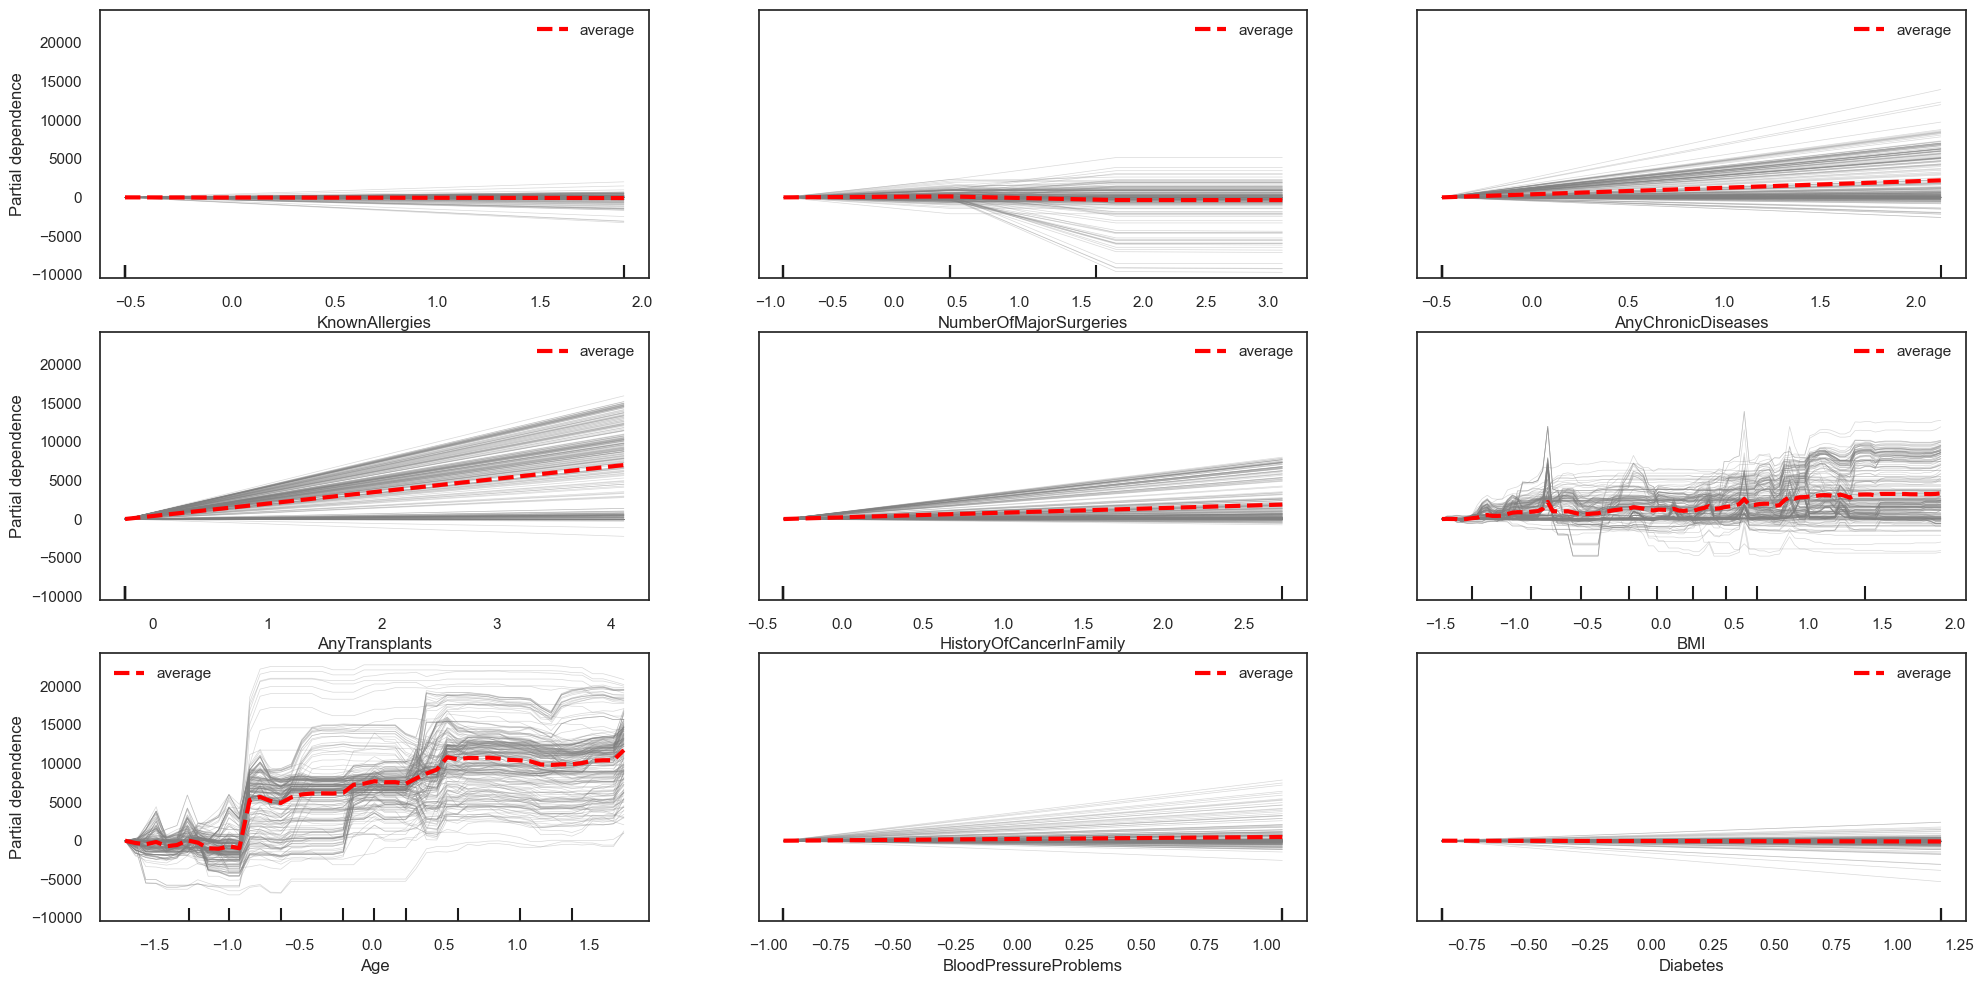

In [ ]:
cols = xtest.columns
# Determine the 9 features with highest value for "feature importance" to draw the ICE plots.
included_features_indices = np.argpartition(rfmodel0.feature_importances_, -9)[-9:]

# Plot the ICE plots.
fig, ax = plt.subplots(figsize=(20, 10))
fig.set_tight_layout(True)  # Make sure labels of axes don't overlap in the final figure.
_ = PartialDependenceDisplay.from_estimator(estimator=rfmodel0,
                                            ax=ax,
                                            X=xtest,
                                            features=[i for i in included_features_indices],
                                            feature_names=cols,
                                            n_cols=3,
                                            centered= True,
                                            kind='both',
                                            ice_lines_kw={'color': 'gray'},
                                            pd_line_kw={'color': 'red', 'linewidth': 3, 'linestyle': 'dashed'})

# GBM Model

In [ ]:
import time
import psutil

# Record the start time
start_time = time.time()
# Function to get memory usage
def get_memory_usage():
    process = psutil.Process()
    memory_info = process.memory_info()
    return memory_info.rss / (1024 * 1024)  # Convert to megabytes

# Record memory usage before running your code
start_memory = get_memory_usage()



gbmodel0=GradientBoostingRegressor()
gbmodel0.fit(xtrain,ytrain)
ypredtrain3=gbmodel0.predict(xtrain)
ypredtest3=gbmodel0.predict(xtest)
print(r2_score(ytrain,ypredtrain3))
print(r2_score(ytest,ypredtest3))
print(cross_val_score(gbmodel0,xsc,y,cv=5,).mean())
from sklearn.model_selection import GridSearchCV
estimator=GradientBoostingRegressor()
param_grid={'n_estimators':[10,15,19,20,21,50,100],'learning_rate':[0.1,0.19,0.2,0.21,0.8,1]}
grid2=GridSearchCV(estimator,param_grid,scoring="r2",cv=5)
grid2.fit(xtrain,ytrain)
print(grid2.best_params_)

gbmodel=grid2
gbmodel.fit(xtrain,ytrain)
ypredtrain3=gbmodel.predict(xtrain)
ypredtest3=gbmodel.predict(xtest)



acc_GBM_Train = (r2_score(ytrain,ypredtrain3))
print('R^2 Train:', acc_GBM_Train)

acc_GBM_Test = (r2_score(ytest,ypredtest3))
print('R^2 Test:', acc_GBM_Test)

acc_GBM_CV = cross_val_score(gbmodel,xsc,y,cv=5,).mean()
print('R^2 CV:', acc_GBM_CV)


# other metrics

MAE_GBM_Test= metrics.mean_absolute_error(ytest,ypredtest3)
print('MAE:',MAE_GBM_Test)
MSE_GBM_Test = metrics.mean_squared_error(ytest,ypredtest3)
print('MSE:',MSE_GBM_Test)
RMSE_GBM_Test = np.sqrt(metrics.mean_squared_error(ytest,ypredtest3))
print('RMSE:', RMSE_GBM_Test)
MAPE_GBM_Test= (metrics.mean_absolute_percentage_error(ytest,ypredtest3))
print('MAPE:',MAPE_GBM_Test)






0.8635682469956296
0.8415951264529293
0.7267660903677762
{'learning_rate': 0.19, 'n_estimators': 20}
R^2 Train: 0.788689218167839
R^2 Test: 0.8485893317465839
R^2 CV: 0.7320511792321838
MAE: 1730.6474301914495
MSE: 5572619.401513096
RMSE: 2360.6396170345647
MAPE: 0.0723318004431528
Elapsed Time: 103.43985724449158 seconds
Memory Used: 0.4609375 MB


## Learning Curve for GBM model

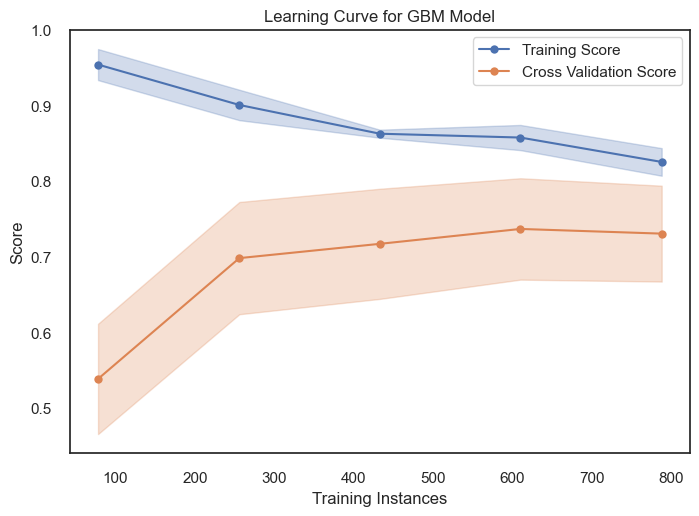

<Axes: title={'center': 'Learning Curve for GBM Model'}, xlabel='Training Instances', ylabel='Score'>

In [ ]:
from yellowbrick.model_selection import learning_curve


visualizer = learning_curve(gbmodel,xsc,y,cv=5, scoring='r2', title="Learning Curve for GBM Model")

visualizer.show()

## Residuals plot + Q-Q plot (yellowbrick) for GBM model

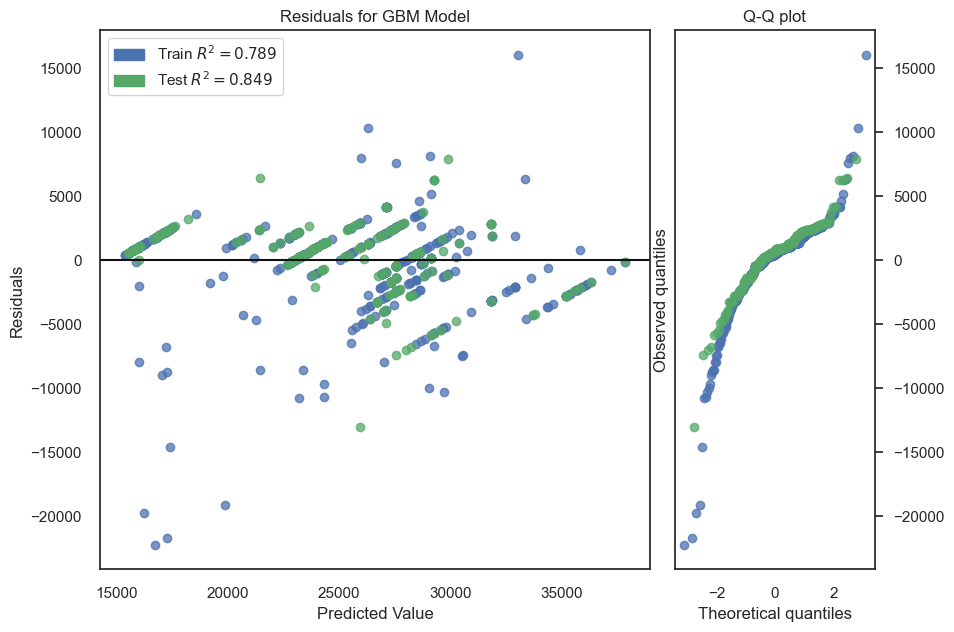

In [ ]:
fig, ax = plt.subplots(figsize=(10, 7))
_ = residuals_plot(estimator=gbmodel,
                   is_fitted=True,
                   ax=ax,
                   X_train=xtrain,
                   y_train=ytrain,
                   X_test=xtest,
                   y_test=ytest,
                   hist=False,
                   qqplot=True,
                  title="Residuals for GBM Model"
                  )

## Prediction error plot (yellowbrick) for GBM model

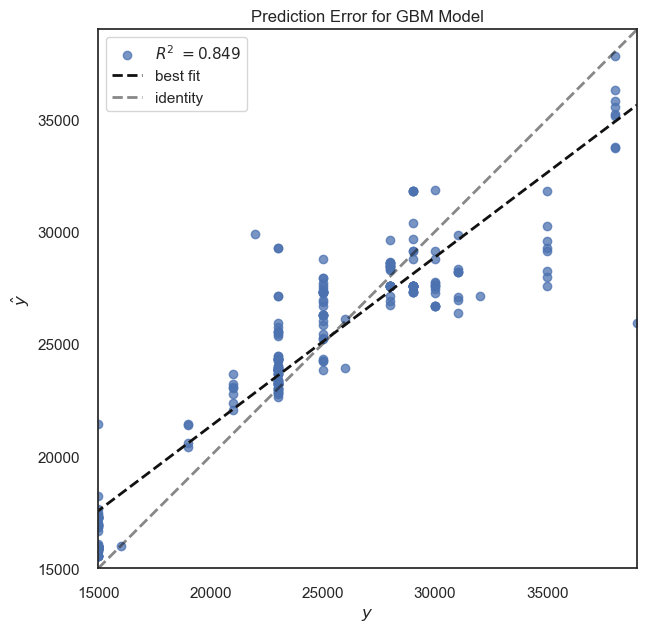

In [ ]:
fig, ax = plt.subplots(figsize=(10, 7))
_ = prediction_error(estimator=gbmodel,
                     is_fitted=True,
                     ax=ax,
                     X_train=xtrain,
                     y_train=ytrain,
                     X_test=xtest,
                     y_test=ytest,
                     title="Prediction Error for GBM Model")

## SHAP Analysis for GBM model

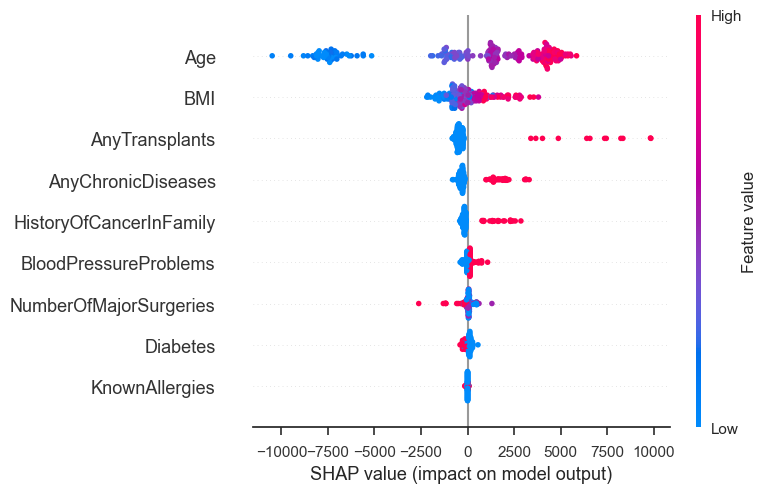

In [ ]:
# Shap analysis for RF model
explainer2 = shap.TreeExplainer(gbmodel0)
GBM_shap_values = explainer2.shap_values(xtest)
shap.summary_plot(GBM_shap_values, xtest)

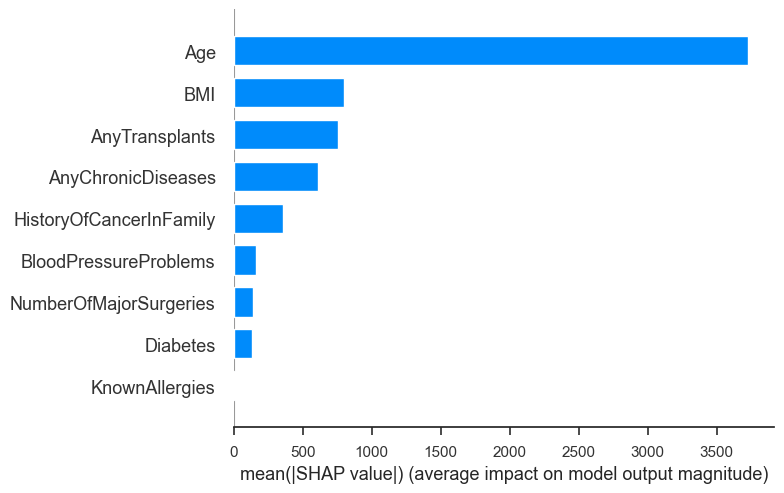

In [ ]:
shap.summary_plot(GBM_shap_values, xtest, plot_type="bar")

## ICE plot for GBM Model

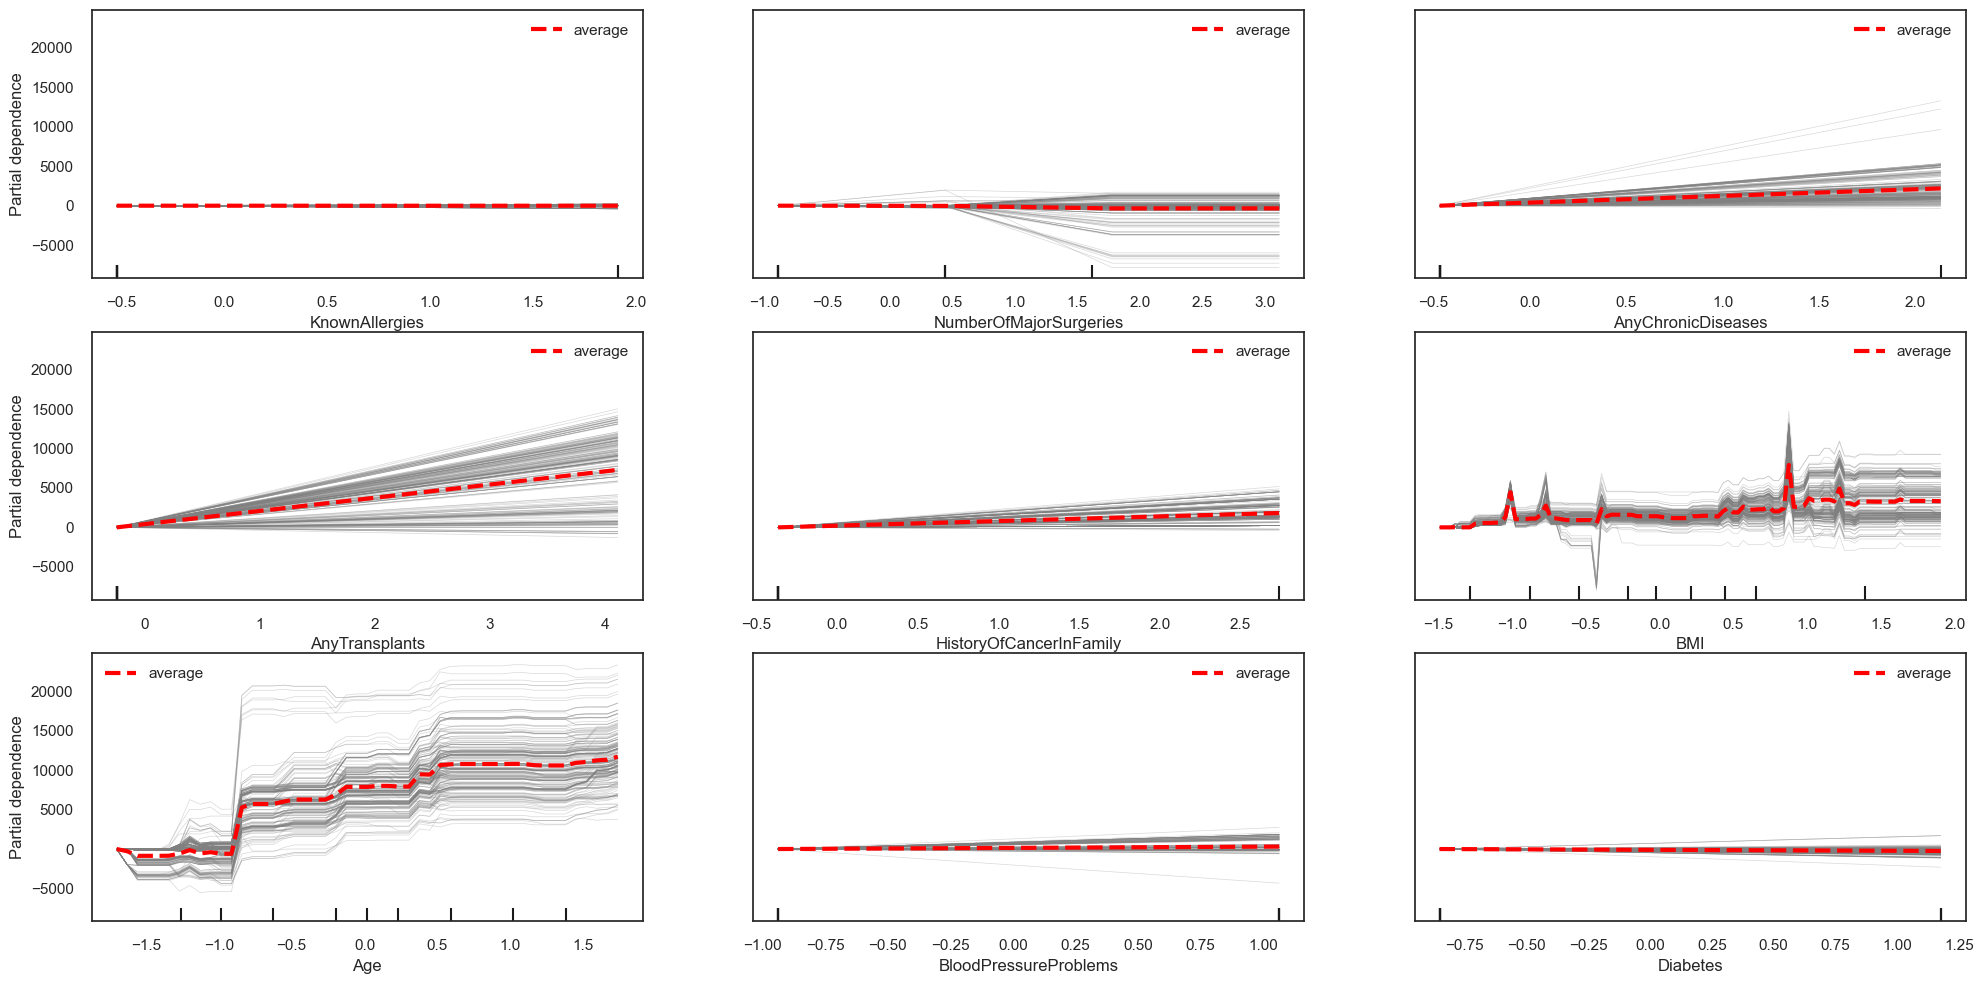

In [ ]:
cols = xtest.columns
# Determine the 9 features with highest value for "feature importance" to draw the ICE plots.
included_features_indices = np.argpartition(gbmodel0.feature_importances_, -9)[-9:]

# Plot the ICE plots.
fig, ax = plt.subplots(figsize=(20, 10))
fig.set_tight_layout(True)  # Make sure labels of axes don't overlap in the final figure.
_ = PartialDependenceDisplay.from_estimator(estimator=gbmodel0,
                                            ax=ax,
                                            X=xtest,
                                            features=[i for i in included_features_indices],
                                            feature_names=cols,
                                            centered= True,
                                            n_cols=3,
                                            kind='both',
                                            ice_lines_kw={'color': 'gray'},
                                            pd_line_kw={'color': 'red', 'linewidth': 3, 'linestyle': 'dashed'})

# XGB Model

In [ ]:
import time
import psutil

# Record the start time
start_time = time.time()
# Function to get memory usage
def get_memory_usage():
    process = psutil.Process()
    memory_info = process.memory_info()
    return memory_info.rss / (1024 * 1024)  # Convert to megabytes

# Record memory usage before running your code
start_memory = get_memory_usage()



xgmodel0=XGBRegressor()
xgmodel0.fit(xtrain,ytrain)
ypredtrain4=xgmodel0.predict(xtrain)
ypredtest4=xgmodel0.predict(xtest)
print(r2_score(ytrain,ypredtrain4))
print(r2_score(ytest,ypredtest4))
print(cross_val_score(xgmodel0,xsc,y,cv=5,).mean())


0.998734912770186
0.7960840678401696
0.6910681258875979


In [ ]:
from sklearn.model_selection import GridSearchCV

estimator=XGBRegressor()
param_grid={'n_estimators':[50,100,150,200],'max_depth':[5,7,10],'gamma':[0,0.15,0.3,0.5,1],
            'learning_rate': [0.1, 0.01, 0.05], 'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}
grid3=GridSearchCV(estimator,param_grid,scoring="r2",cv=5)
grid3.fit(xtrain,ytrain)

print(grid3.best_params_)

xgmodel=grid3
xgmodel.fit(xtrain,ytrain)
ypredtrain4=xgmodel.predict(xtrain)
ypredtest4=xgmodel.predict(xtest)



acc_xgb_Train = (r2_score(ytrain,ypredtrain4))
print('R^2 Train:', acc_xgb_Train)

acc_xgb_Test = (r2_score(ytest,ypredtest4))
print('R^2 Test:', acc_xgb_Test)

acc_xgb_CV = (cross_val_score(xgmodel,xsc,y,cv=5,).mean())
print('R^2 CV:', acc_xgb_CV)


# other metrics



{'gamma': 0, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}
R^2 Train: 0.9064896106719971
R^2 Test: 0.8490304350852966
R^2 CV: 0.7471449971199036
